# 10 minutes to... understand the new dynamical spinup in OGGM v1.6

In this example, we show case a recent addition to OGGM: the dynamical spinup during the historical period. We explain in the tutorial why this was added and how it works.

In [1]:
# Libs
import xarray as xr
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, DEFAULT_BASE_URL
from oggm.shop import gcm_climate

## Accessing the pre-processed directories including spinup runs

Let's focus on our usual suspect glacier: Hintereisferner.

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_gcm_run', reset=True)

# RGI glacier 
rgi_ids = 'RGI60-11.00897'

2023-08-24 21:57:39: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-08-24 21:57:39: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-08-24 21:57:39: oggm.cfg: Multiprocessing: using all available processors (N=16)


To fetch the preprocessed directories including spinup, we have to tell OGGM where to find them. The default URL contains the runs with spinup:

In [3]:
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_base_url=DEFAULT_BASE_URL)

2023-08-24 21:57:39: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2023-08-24 21:57:39: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## A new workflow including a recalibration

These directories are very similar to the "old" ones (same input data, same baseline climate...). But in addition, they include a new historical simulation run with a dynamic spinup. Let's open it and compare it to the old historical run without a spinup:

2023-08-24 21:57:39: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 21:57:39: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-08-24 21:57:39: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 21:57:39: oggm.utils: Applying compile_run_output on 1 gdirs.


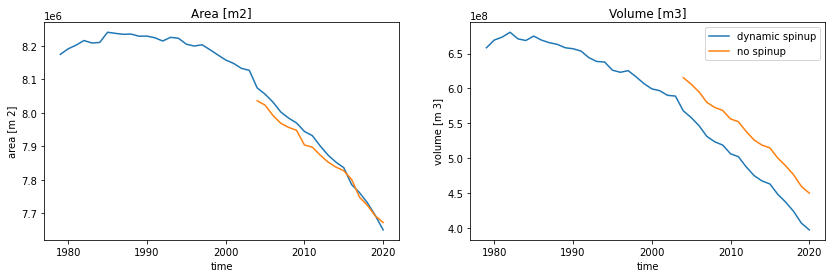

In [4]:
# open the new historical run including a dynamic spinup
ds_spinup = utils.compile_run_output(gdirs, input_filesuffix='_spinup_historical')

# open the old historical run without a spinup
ds_historical = utils.compile_run_output(gdirs, input_filesuffix='_historical')

# compare area and volume evolution
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Area
ds_spinup.area.plot(ax=ax1, label='dynamic spinup')
ds_historical.area.plot(ax=ax1, label='no spinup')
ax1.set_title('Area [m2]')

# Volume
ds_spinup.volume.plot(ax=ax2, label='dynamic spinup')
ds_historical.volume.plot(ax=ax2, label='no spinup')
ax2.set_title('Volume [m3]')

plt.legend();

Let's have a look at what happens here.

### Dynamic spinup run extends further back in time

The first thing to notice is that the new dynamic spinup run extends further back in time, starting in 1979 compared to 2003 (the RGI date for this glacier).

In [5]:
gdirs[0].rgi_date

2003

We achieve this by searching for a glacier state in 1979 which evolves to match the area at the RGI date. Therefore, you can see that the areas around the RGI date (2003) are very close.

However, the volumes show some difference around the RGI date, as we did not attempt to match the volume. The current workflow can match area OR volume and, by default, we decided to match area as it is a direct observation (from the RGI outlines), in contrast to a model guess for the volume (e.g. [Farinotti et al. 2019](https://www.nature.com/articles/s41561-019-0300-3)).

### Dynamical spinup also uses a dynamically recalibrated melt factor *melt_f*

The second big difference is not directly visible, but during the dynamic spinup, we check that the dynamically modelled geodetic mass balance fits the given observations from [Hugonnet et al. 2021](https://www.nature.com/articles/s41586-021-03436-z). To achieve this, we use the *melt_f* of the mass balance as a tuning variable.

We need this step because the initial mass balance model calibration (see this [tutorial](../advanced/massbalance_calibration.ipynb)) assumes constant glacier surface geometry, as defined by the RGI outline. However, the observed geodetic mass balance also contains surface geometry changes, which we only can consider during a dynamic model run.

Let's check that the dynamically calibrated geodetic mass balance fits the given observations:

In [6]:
gdir = gdirs[0]

# period of geodetic mass balance
ref_period = cfg.PARAMS['geodetic_mb_period']

# open the observation with uncertainty
df_ref_dmdtda = utils.get_geodetic_mb_dataframe().loc[gdir.rgi_id]  # get the data from Hugonnet et al., 2021
df_ref_dmdtda = df_ref_dmdtda.loc[df_ref_dmdtda['period'] == ref_period]  # only select the desired period
dmdtda_reference = df_ref_dmdtda['dmdtda'].values[0] * 1000  # get the reference dmdtda and convert into kg m-2 yr-1
dmdtda_reference_error = df_ref_dmdtda['err_dmdtda'].values[0] * 1000  # corresponding uncertainty

# calculate dynamic geodetic mass balance
def get_dmdtda(ds):
    yr0_ref_mb, yr1_ref_mb = ref_period.split('_')
    yr0_ref_mb = int(yr0_ref_mb.split('-')[0])
    yr1_ref_mb = int(yr1_ref_mb.split('-')[0])

    return ((ds.volume.loc[yr1_ref_mb].values -
             ds.volume.loc[yr0_ref_mb].values) /
            gdir.rgi_area_m2 /
            (yr1_ref_mb - yr0_ref_mb) *
            cfg.PARAMS['ice_density'])

print(f'Reference dmdtda 2000 to 2020 (Hugonnet 2021): {dmdtda_reference:.2f} +/- {dmdtda_reference_error:6.2f} kg m-2 yr-1')
print(f'Dynamic spinup dmdtda 2000 to 2020:            {float(get_dmdtda(ds_spinup)):.2f}            kg m-2 yr-1')
print(f"Dynamically calibrated melt_f:                 {gdir.read_json('mb_calib')['melt_f']:.1f}                 kg m-2 day-1 °C-1")

Reference dmdtda 2000 to 2020 (Hugonnet 2021): -1100.30 +/- 171.80 kg m-2 yr-1
Dynamic spinup dmdtda 2000 to 2020:            -1130.19            kg m-2 yr-1
Dynamically calibrated melt_f:                 4.9                 kg m-2 day-1 °C-1


This fits quite well! The default in OGGM is to try to match the observations within 20% of the reported error by Hugonnet et al. This is a model option, and can be changed at wish.

### Dynamical spinup addresses "initial shock" problems

This is not really visible in the plots above, but the "old" method of initialisation in OGGM had another issue. It assumed dynamical steady state at the begining of the simulation (the RGI date), which was required by the bed inversion process. This could lead to artifacts (mainly in the glacier length and area, as well as velocities) during the first few years of the simulation. The dynamical spinup addresses this issue by starting the simulation in 1979.

In [7]:
# TODO: showcase the velocities in the fl diagnostics

## Using the dynamic spinup in your workflow

We recommend that you use the provided preprocessed directories for your analysis. However, if you want to learn more about how the dynamic spinup works in detail or if you plan to use it in your workflow, maybe with different data, you should check out the more comprehensive tutorial: [Dynamic spinup and dynamic melt_f calibration for past simulations](../advanced/dynamical_spinup.ipynb). And do not hesitate to [reach out](https://docs.oggm.org/en/stable/#get-in-touch) if you have any questions!

## What's next?

- Look at the more comprehensive tutorial [Dynamic spinup and dynamic melt_f calibration for past simulations](../advanced/dynamical_spinup.ipynb)
- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](../welcome.ipynb)